### Miniproject Henrik Ågotnes

In [1]:
import numpy as np
import time

import code
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from skimage import io, transform

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
print('modules imported')


_path = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/annotations/xmls/Norway_002967.xml'
xml_paths = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/annotations/xmls'
image_path = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/images'






class RoadDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train=True,transform=None, country='Norway'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/' + country +'/'
        self.path_train_or_test = 'train' if train else 'test'
        self.country = country
        self.n_samples = 8160 if train else 2040
        self.image_dir = os.path.join(self.root_dir,self.path_train_or_test, 'images')
        self.annotation_dir = os.path.join(self.root_dir,self.path_train_or_test, 'annotations', 'xmls')
        

        #self.root_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/'
        #self.image_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/images/'
        #self.annotation_dir = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/Norway/train/annotations/xmls/'
        self.transform = transform

        self.img_shape = (3, 2044, 3650)
        self.num_classes = 4

        self.transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float)])
        self.crack_name_to_label = {
            'D00': 1,
            'D10': 2,
            'D20': 3,
            'D40': 4,
        }
        self.num_classes = 4
        

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.path_train_or_test == 'test':
            idx = idx + 8161

        img_name = os.path.join(self.image_dir, self.country + '_'
                                 + f'{idx:06d}' + '.jpg')
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)
        if self.path_train_or_test == 'test':
            return image, {'image_id': idx}

        annotation_name = os.path.join(self.annotation_dir, self.country +'_' + f'{idx:06d}' + '.xml')
        root = ET.parse(annotation_name).getroot()
        labels, boxes = ([], [])
        for _object in root.findall("object"):
            name = _object.find('name').text
            if name in self.crack_name_to_label:
                labels.append(self.crack_name_to_label[name])
            #labels.append(self.crack_name_to_label[_object.find('name').text])
            boxes.append([float(i.text) for i in _object.find('bndbox')])
            if _object.find('name').text not in self.crack_name_to_label:
                print('[WARNING]Found where object name:', _object.find('name').text)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxes = torch.tensor(boxes, dtype=torch.float32)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}



        return image, target
    
    def get_pil(self, idx):
        img_name = os.path.join(self.image_dir,
                                'Norway_' + f'{idx:06d}' + '.jpg')
        return Image.open(img_name).convert("RGB") # transforms.functional.pil_to_tensor(




/cluster/home/henrikya/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


modules imported


### Transforms

In [2]:
import albumentations as A
import cv2


transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc'))
transformed = transform(image=images[0], bboxes=targets[0]['boxes'], category_ids=targets[0]['boxes'])

NameError: name 'images' is not defined

### Dataloaders setup

In [2]:
def collate_fn(batch):
    return tuple(zip(*batch))
road_dataset = RoadDataset(train=True)

train_size = int(len(road_dataset) * 0.75)
val_size = len(road_dataset) - train_size
train_size, val_size
train_data, val_data = torch.utils.data.random_split(road_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
test_data = RoadDataset(train=False)

train_data_loader = DataLoader(train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)
val_data_loader = DataLoader(val_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)
test_data_loader = DataLoader(test_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=collate_fn)

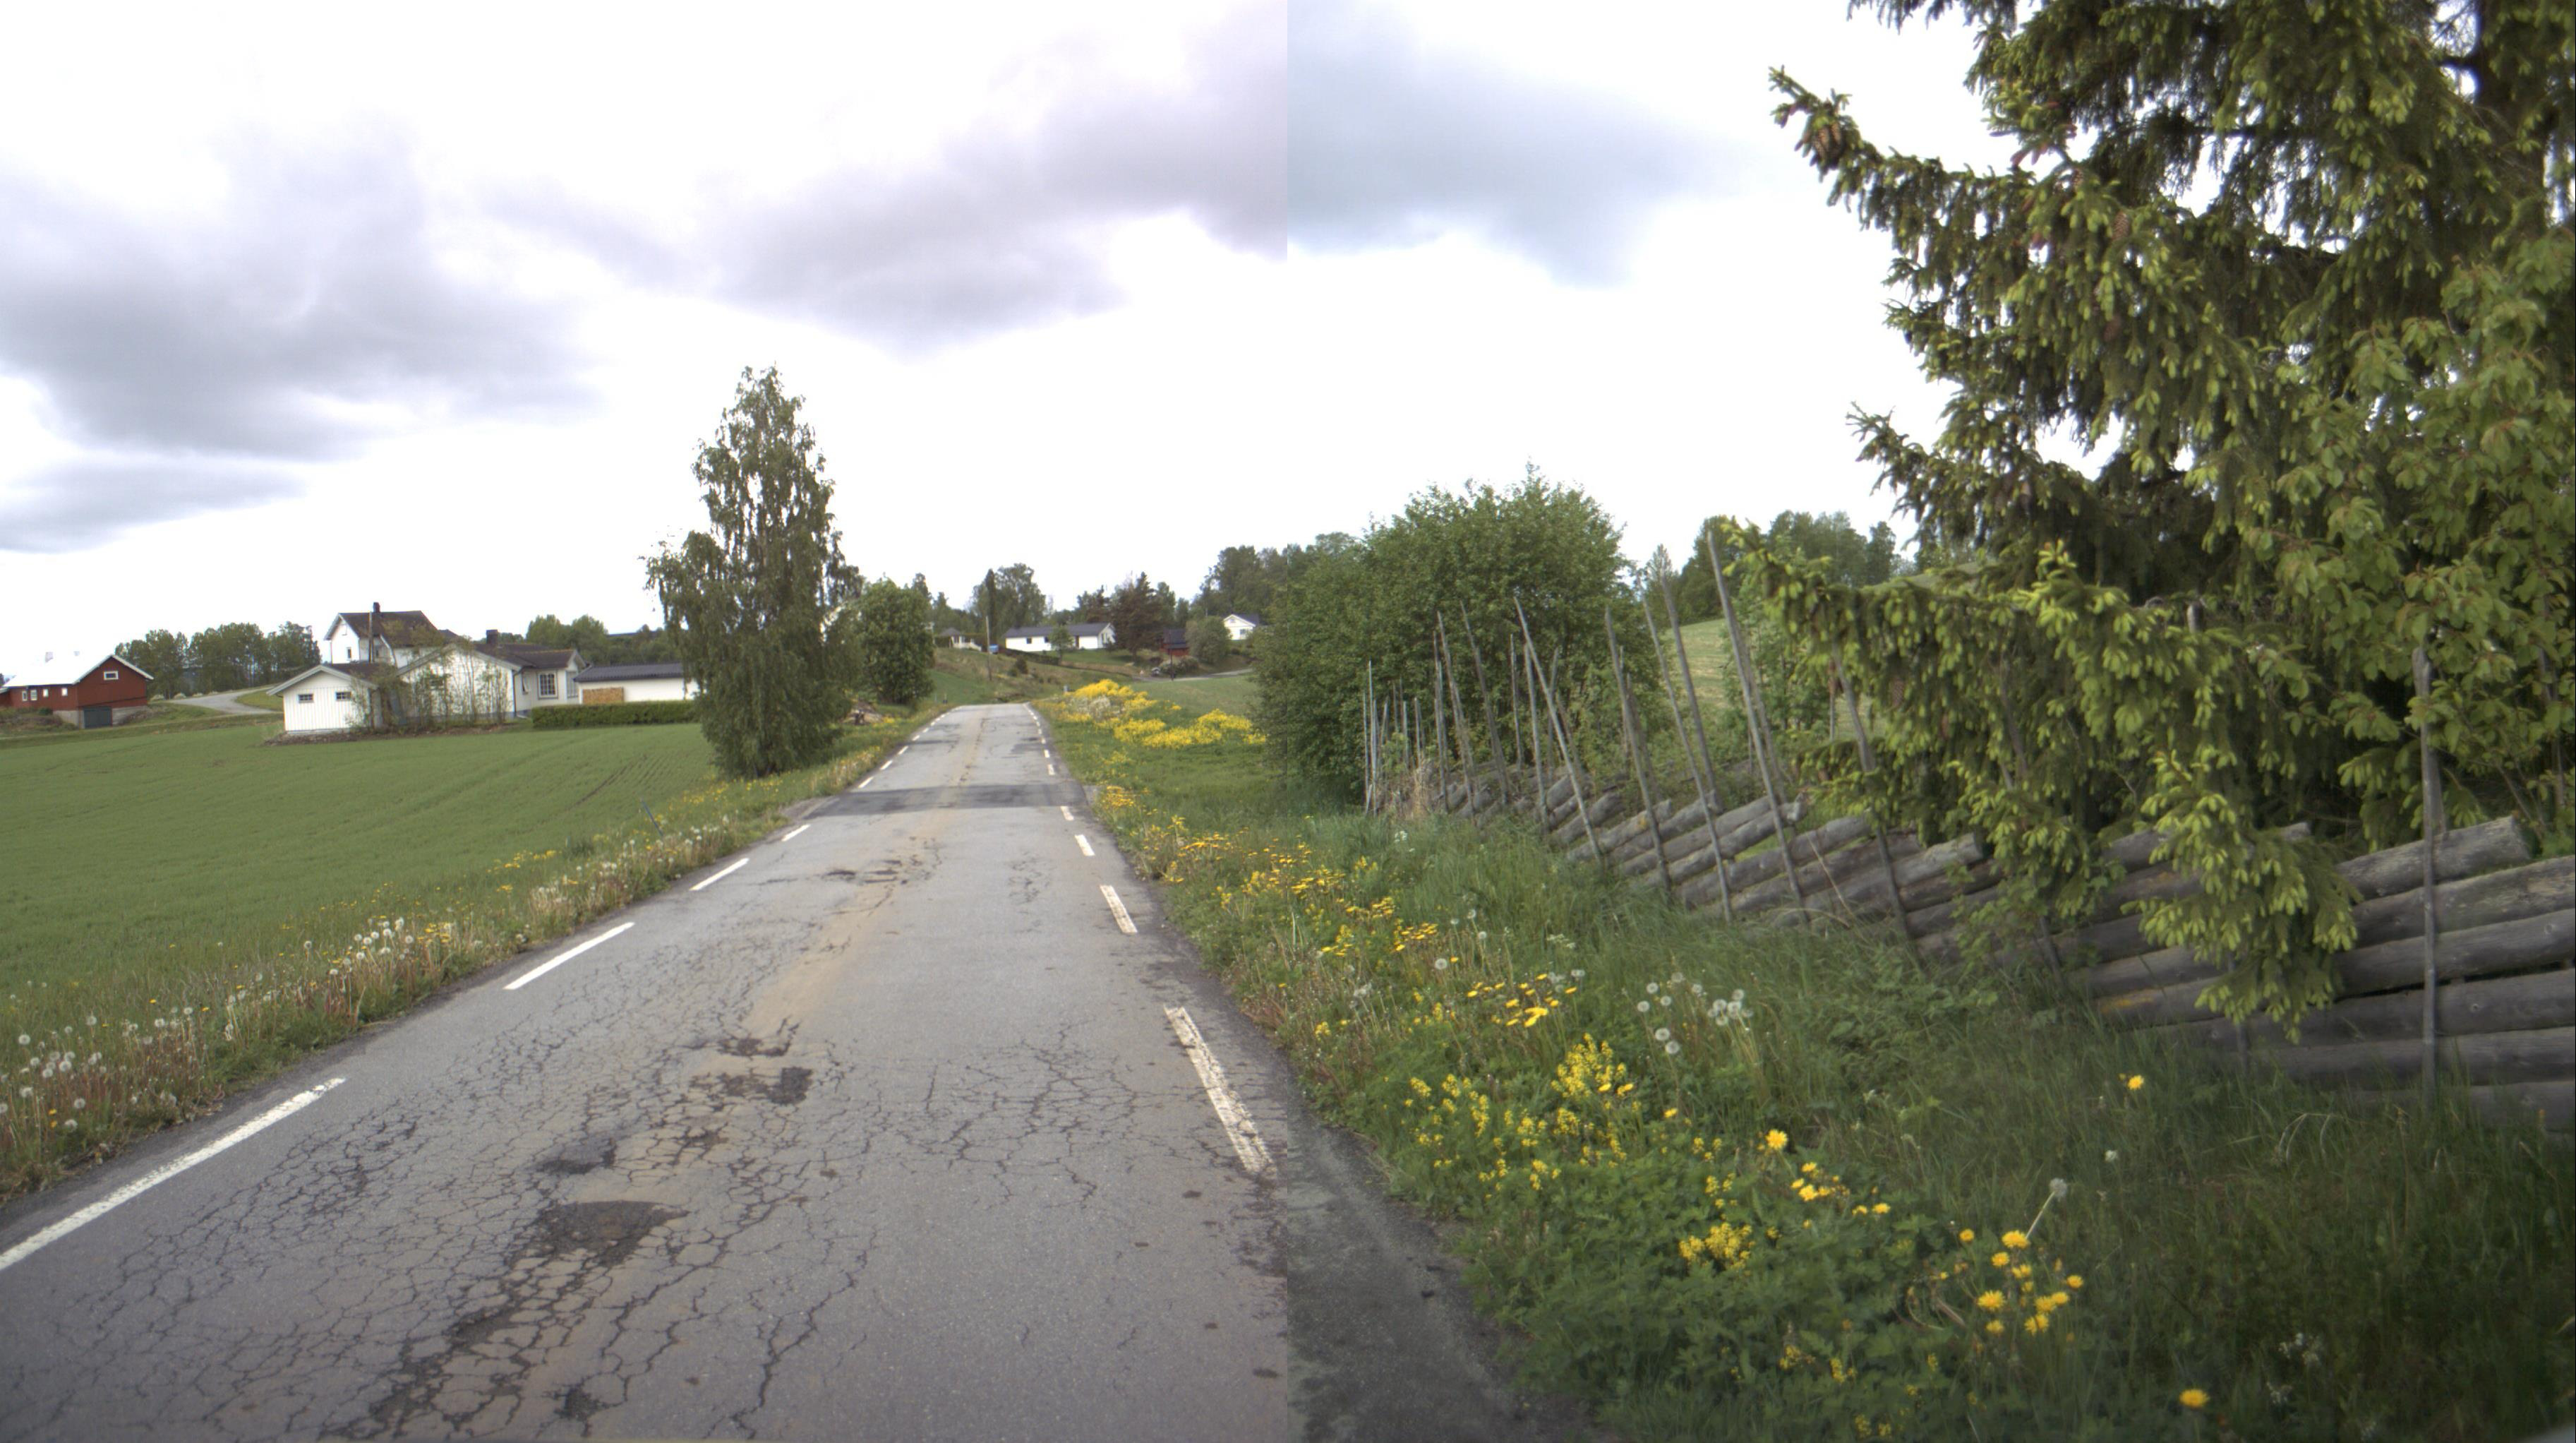

In [6]:
img = road_dataset.get_pil(9)
img

In [8]:
draw = ImageDraw.Draw(img)
draw.rectangle(((0, 00), (100, 100)), fill="black")
#draw.text((20, 70), "something123", font=ImageFont.truetype("font_path123"))
img.save("images/test1.jpg", "JPEG")


In [ ]:
im, target = road_dataset[20]

In [ ]:
target

In [ ]:
road_dataset[0]

In [ ]:
next(iter(test_data_loader))

### Make model

In [ ]:
# Problems with packages.
# yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', autoshape=False, pretrained= True)  # load pretrained


In [3]:
# Model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 5  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to('cpu') # TODO Change to device when running!!

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Test forward

In [ ]:
images,targets = next(iter(train_data_loader))

In [ ]:
targets

In [ ]:
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images,targets)

In [ ]:
output

In [ ]:
sum([loss for loss in output.values()])

In [10]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


### Train loop

In [ ]:

model.train()
for epoch in range(10):
    break
    print(f'Epoch: {epoch}')

    for image, target in train_data_loader:
        loss_dict = model(images, target)
        losses = sum(loss for loss in loss_dict.values())
        print(f'Gott {losses=}')
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        break
    break


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
batch_i = 0

model.train()
model.to(device)
start =time.time()
for epoch in range(10):
    print(f'[Epoch: {epoch}]:')

    for images, targets in train_data_loader:
        print(batch_i, type(images), type(targets))
        
        x, y = ([], [])
        for image, target in zip(images, targets):
            if len(target['labels']) > 0:
                x.append(image.to(device))
                y.append({k: v.to(device) for k, v in target.items()}) # [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(x) <= 0:
            continue

            
        loss_dict = model(x, y)
        losses = sum(loss for loss in loss_dict.values())
        # TODO report loss
        print(f'   Losses are: {losses=}')
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        if time.time() - start > 1800.0:
            break
    
    save_model_path = os.path.join( '/cluster/home/henrikya/object_detection/saved_models/', f'torch_e{epoch}_batch_{batch_i}.pt')
    #torch.save(model.state_dict(), save_model_path)
    if time.time() - start > 1800.0:
            break
    


In [ ]:
epoch
batch_i = 5

In [ ]:

save_model_path = os.path.join( '/cluster/home/henrikya/object_detection/saved_models/', f'torch_e{epoch}_batch_{batch_i}.pt')
torch.save(model.state_dict(), save_model_path)


In [ ]:
train_data[7][1]

### Evaluate


mAP@0.50,…, 0.05,…,.95

In [7]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

iou_tresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]


metric = MeanAveragePrecision(iou_thresholds=iou_tresholds)
# metric demo:

#metric.update(list(preds), list(targets))
# metric.compute()

In [4]:
device = 'cuda'
model.to(device) # TODO Change to device when running!!
PATH = '/cluster/home/henrikya/object_detection/saved_models/backup/torch_e0_batch_237.pt'
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [13]:
device = 'cpu'
model.to(device) # TODO Change to device when running!!
model.eval()
evals = []

for images, targets in train_data_loader: # val_data_loader
    x, y = ([], [])
    for image, target in zip(images, targets):
        if len(target['labels']) > 0:
            x.append(image.to(device))
            y.append({k: v.to(device) for k, v in target.items()}) # [{k: v.to(device) for k, v in t.items()} for t in targets]
    if len(x) <= 0:
        continue
    with torch.no_grad():
        model_time = time.time()
        preds = model(x)
        print(preds)
        model_time = time.time() - model_time
    metric.update(preds, y)
    break
    print(metric(preds, targets))
    #
    evals.append(model_time)

map_dict = metric.compute()
map_dict


[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_cat)

In [12]:
y, preds

([{'boxes': tensor([[1798.3400, 1549.4600, 1970.4900, 1684.9800],
           [2464.9600, 1928.5500, 2670.0701, 2034.7700],
           [1465.0300, 1816.8400, 1659.1600, 2027.4500],
           [ 203.2200, 1327.8600,  626.2700, 1386.4700],
           [ 416.2400, 1183.2500,  669.4500, 1333.3199],
           [1410.9900, 1676.8900, 1493.6500, 1718.2300],
           [ 717.4500, 1172.8700,  819.7500, 1188.3300],
           [ 711.2900, 1092.9600,  820.7900, 1179.4399]], device='cuda:0'),
   'labels': tensor([1, 1, 4, 2, 1, 4, 2, 1], device='cuda:0'),
   'image_id': tensor([6387], device='cuda:0')}],
 [{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
   'labels': tensor([], device='cuda:0', dtype=torch.int64),
   'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}])

IndexError: list index out of range

### Submission

In [ ]:
# 2 cols

class Submission:
    """
    ImageId: the id of the test image, for example, India_00001
    PredictionString: the prediction string should be space-delimited of 5 integers. For example, 2 240 170 260 240 means
    it's label 2, with a bounding box of coordinates (x_min, y_min, x_max, y_max). We accept up to 5 predictions. 
    For example, if you submit: 
    3 42 24 170 186 1 292 28 430 198 4 168 24 292 190 5 299 238 443 374 2 160 195 294 357 6 1 224 135 356 
    which contains 6 bounding boxes, we will only take the first 5 into consideration.
    """
    
    def __init__(self) -> None:
        self.n_preds = len(test_data)

        self.submission = pd.DataFrame({'ImageId':['INVALID' for i in range(self.n_preds)], 'PredictionString':['INVALID' for i in range(self.n_preds)]})

        self.submission.index = [i + 8161 for i in range(self.n_preds)]

    def add_batch_preds(self, preds, targets):
        for pred, target in zip(preds, targets):
            idx = target['image_id']
            self.submission.loc[idx, 'ImageId'] = f'Norway_{idx:06d}'
            # use threshold
            # select only 5 highest above threshold
            objectness_treshold = 0.6
            self.submission.loc[idx, 'PredictionString'] = None
    

In [ ]:
submission = Submission()
model.eval()

for images, targets in test_data_loader:

    preds = model(images)
    submission.add_batch_preds(preds, targets)
    break

In [ ]:
pred = preds[0]
pred['labels'], pred['scores']

In [ ]:
test_data[0]

In [ ]:
f"{test_data[0][1]['image_id']}"
idx = test_data[0][1]['image_id']
print(f'Norway_{idx:06d}')

In [ ]:
idx

In [ ]:
os.path.join('Norway' + '_'+ f'{idx:06d}' + '.jpg')

In [ ]:
n_preds = len(test_data)

submission = pd.DataFrame({'ImageId':['INVALID' for i in range(n_preds)], 'PredictionString':['INVALID' for i in range(n_preds)]})

submission.index = [i + 8161 for i in range(n_preds)]
submission

### Memory usage

In [ ]:
#np.zeros((10000, 10000))
import psutil

#svmem(total=16717422592, available=5376126976, percent=67.8, used=10359984128, free=1831890944, active=7191916544, inactive=2325667840, buffers=525037568, cached=4000509952, shared=626225152)
arr = np.zeros((5000, 1000))
psutil.virtual_memory()

In [ ]:
psutil.virtual_memory()

### Temp experimentation

In [ ]:
t

In [ ]:
metric

In [ ]:
preds, targets

In [ ]:
metric.compute()

In [ ]:
list(targets)

In [ ]:
list(preds[0].keys()), list(targets[0].keys())

In [ ]:
preds[0]['scores']

In [ ]:
loss_dict

In [ ]:
preds[0]['scores']

In [ ]:
metric.compute()

In [ ]:
preds[0]['scores']

In [ ]:
box_img = torchvision.utils.draw_bounding_boxes(torchvision.transforms.functional.pil_to_tensor(images[0]), preds[0]['boxes'], preds[0]['labels'])
box_img

In [ ]:
box_img = torchvision.utils.draw_bounding_boxes( images[0].to(torch.uint8),targets[1]['boxes'], targets[1]['labels'])
box_img

In [ ]:
targets[1]['boxes'].dtype, targets[1]['labels'].dtype

In [ ]:
targets[1]['labels'][0]

In [ ]:
images[0].to(torch.uint8)

In [ ]:
road_dataset.get_pil(torch.tensor(targets[0]['image_id'].item()).dtype

In [ ]:
torch.tensor(images[0], dtype=torch.uint8)

In [ ]:
type(images[0]), type(preds[0]['boxes']), type(preds[0]['labels'])

In [ ]:
targets